In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quickdraw-doodle-recognition/test_raw.csv
/kaggle/input/quickdraw-doodle-recognition/test_simplified.csv
/kaggle/input/quickdraw-doodle-recognition/sample_submission.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/frying pan.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/door.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/toe.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/paint can.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/zigzag.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/megaphone.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/t-shirt.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/flip flops.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/ocean.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/mouse.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/calendar.csv
/kaggle/input/quickdraw-doodle-recognition/train_raw/squiggle.csv
/kaggle/input/quickdraw-doodle-recog

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook')

np.random.seed(36)

Deep Learning Packages

In [3]:
import ast
import cv2
import dask.bag as db

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19

Using TensorFlow backend.


Loading Data

Since the file is very huge we are taking only 50 animals as sample

In [4]:
# list of animals 
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']

Taking only one animal from the list to analyze the columns.

In [5]:
dir_path='/kaggle/input/quickdraw-doodle-recognition/train_simplified/'
df = pd.read_csv(dir_path + animals[0] + '.csv')
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


## Important Features
* Drawing is the stroke values, which is telling the drawing of animals.We need to exchage this data into image data
* Recognized is whether it recognized a drawing.
* word indicates the result of drawings or animals

We are taking 100 rows per animal and only taking recognized images

In [6]:
am = pd.DataFrame(columns = df.columns)

for i in range(len(animals)):
    filename = dir_path + animals[i] + '.csv'
    df = pd.read_csv(filename, nrows = 100)
    df = df[df.recognized == True]
    am = am.append(df)

In [7]:
am.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


In [8]:
am.word.nunique()

50

As we can see there are 50 unique animals

Visulizing the Drawings

* Let's See how people drew animals.
*  The image information can be found at drawing but in order to make it visual, we need some steps of processing. 
* Let's take only 100 data for an example.

In [9]:
# Sampling only 100 examples
ex = am.sample(100)
# Convert to list as drawing columns is in strings
ex['drawing'] = ex.drawing.map(ast.literal_eval)

## Plotting Sample 100 Strokes 

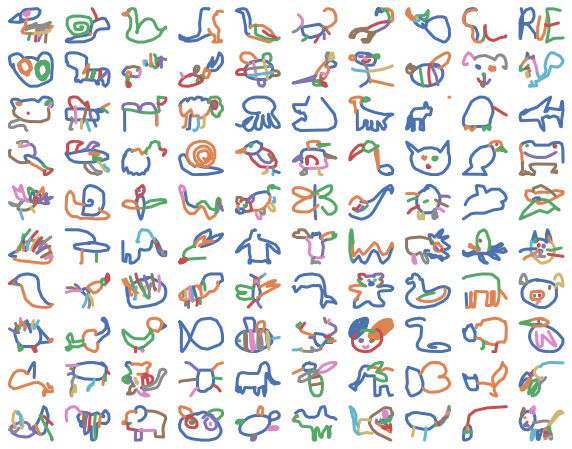

In [10]:
fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 8))

for index, col in enumerate(ex.drawing):
    ax = axs[index//10, index%10]
    for x, y in col:
        ax.plot(x,-np.array(y), lw = 3)
    ax.axis('off')
    
plt.show()

## Strokes to Images
*  The data isn't in the form of image data.
* We have to covert it into numpy array format

In [11]:
im_size = 64
n_class = len(animals)

# redefine
def draw_to_img(strokes, im_size = im_size):
    fig, ax = plt.subplots()                        # plot the drawing as we did above
    for x, y in strokes:
        ax.plot(x, -np.array(y), lw = 10)
    ax.axis('off')
    
    fig.canvas.draw()                               # update a figure that has been altered
    A = np.array(fig.canvas.renderer._renderer)     # converting them into array
    
    plt.close('all')
    plt.clf()
    
    A = (cv2.resize(A, (im_size, im_size)) / 255.)  # image resizing to uniform format

    return A[:, :, :3]        

Check the function with one image

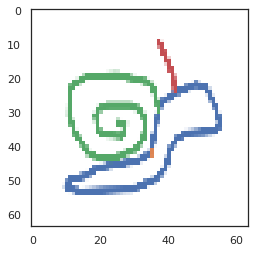

In [12]:
X = ex.drawing.values
image = draw_to_img(X[1])
plt.imshow(image)

Checking shape

In [13]:
image.shape

(64, 64, 3)

We can apply for these methods for our entire dataset.

In [14]:
im_size = 64
n_class = len(animals)
n_samples = 500
X_train = np.zeros((1, im_size, im_size, 3))
y = []

for a in animals:
    #print(a)
    filename = dir_path + a + '.csv'
    df = pd.read_csv(filename, usecols=['drawing', 'word'], nrows=n_samples)  # import the data in chunks
    df['drawing'] = df.drawing.map(ast.literal_eval)                          # convert strings into list
    X = df.drawing.values
    
    img_bag = db.from_sequence(X).map(draw_to_img)                            # covert strokes into array
    X = np.array(img_bag.compute())  
    X_train = np.vstack((X_train, X))                                         # concatenate to get X_train  
    
    y.append(df.word)

In [15]:
X_train.shape

(25001, 64, 64, 3)

In [16]:
# Drop the first layer
X_train = X_train[1:, :, :, :]
X_train.shape

(25000, 64, 64, 3)

In [17]:
#Encoding 
y = pd.DataFrame(y)
y = pd.get_dummies(y)
y_train = np.array(y).transpose()

In [18]:
#Training data
print("The input shape is {}".format(X_train.shape))
print("The output shape is {}".format(y_train.shape))

The input shape is (25000, 64, 64, 3)
The output shape is (25000, 50)


In [19]:
X_train[0][1][2]

array([1., 1., 1.])

Now let's combine the X_train and y_train again. This is for splitting the data into the trainning set and validation set.

In [20]:
# Reshape X_train
X_train_2 = X_train.reshape((X_train.shape[0], im_size*im_size*3))

# Concatenate X_train and y_train
X_y_train = np.hstack((X_train_2, y_train))

Sepearting train and validation set

In [21]:
# Random shuffle
np.random.shuffle(X_y_train)
a = im_size*im_size*3
cut = int(len(X_y_train) * .1)
X_val = X_y_train[:cut, :a]
y_val = X_y_train[:cut, a:]
X_train = X_y_train[cut:, :a]
y_train = X_y_train[cut:, a:]

# Reshape X_train back to (64, 64)
X_train = X_train.reshape((X_train.shape[0], im_size, im_size, 3))
X_val = X_val.reshape((X_val.shape[0], im_size, im_size, 3))

In [22]:
#final Shape
print("The input shape of train set is {}".format(X_train.shape))
print("The input shape of validation set is {}".format(X_val.shape))
print("The output shape of train set is {}".format(y_train.shape))
print("The output shape of validation set is {}".format(y_val.shape))

The input shape of train set is (22500, 64, 64, 3)
The input shape of validation set is (2500, 64, 64, 3)
The output shape of train set is (22500, 50)
The output shape of validation set is (2500, 50)


# CNN Base Model.

In [23]:
n_epochs = 10
batch_size = 500

# Initialize
model = Sequential()

# ConvNet_1
model.add(Conv2D(32, kernel_size = 3, input_shape = (im_size, im_size, 3), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))
# Dropout
model.add(Dropout(.2))

# ConvNet_2
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))
# Dropout
model.add(Dropout(.2))

# ConvNet_3
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))
# Dropout
model.add(Dropout(.2))

# Flattening
model.add(Flatten())

# Fully connected
model.add(Dense(680, activation = 'relu'))

# Dropout
model.add(Dropout(.5))

# Final layer
model.add(Dense(n_class, activation = 'softmax'))

# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)       

In [25]:
# Fitting baseline
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                    validation_split = .2, verbose = True)

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 74s 4ms/step - loss: 3.9184 - accuracy: 0.0212 - val_loss: 3.9124 - val_accuracy: 0.0162
Epoch 2/10
18000/18000 [==============================] - 72s 4ms/step - loss: 3.9122 - accuracy: 0.0198 - val_loss: 3.9129 - val_accuracy: 0.0162
Epoch 3/10
18000/18000 [==============================] - 73s 4ms/step - loss: 3.9121 - accuracy: 0.0202 - val_loss: 3.9133 - val_accuracy: 0.0162
Epoch 4/10
18000/18000 [==============================] - 72s 4ms/step - loss: 3.9118 - accuracy: 0.0208 - val_loss: 3.9140 - val_accuracy: 0.0162
Epoch 5/10
18000/18000 [==============================] - 75s 4ms/step - loss: 3.9119 - accuracy: 0.0206 - val_loss: 3.9143 - val_accuracy: 0.0162
Epoch 6/10
18000/18000 [==============================] - 73s 4ms/step - loss: 3.9119 - accuracy: 0.0209 - val_loss: 3.9141 - val_accuracy: 0.0162
Epoch 7/10
18000/18000 [==============================] - 72s 4ms/ste

# Modeling with ResNet50

It's seem not good. Let's try other pre-trained model.

In [26]:
# ResNet50 Application 
model_r = ResNet50(include_top = True, weights= None, input_shape=(im_size, im_size, 3), classes = n_class)

In [27]:
model_r.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_r.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [28]:
n_epochs = 5
batch_size = 50

In [29]:
# Fitting ResNet50
history_r = model_r.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                      validation_split = .2, verbose = True)

Train on 18000 samples, validate on 4500 samples
Epoch 1/5
18000/18000 [==============================] - 1220s 68ms/step - loss: 4.4578 - accuracy: 0.0201 - val_loss: 4.4926 - val_accuracy: 0.0189
Epoch 2/5
18000/18000 [==============================] - 1190s 66ms/step - loss: 4.1492 - accuracy: 0.0191 - val_loss: 4.1525 - val_accuracy: 0.0244
Epoch 3/5
18000/18000 [==============================] - 1190s 66ms/step - loss: 4.0775 - accuracy: 0.0227 - val_loss: 4.2201 - val_accuracy: 0.0189
Epoch 4/5
18000/18000 [==============================] - 1185s 66ms/step - loss: 4.0335 - accuracy: 0.0230 - val_loss: 4.0192 - val_accuracy: 0.0171
Epoch 5/5
18000/18000 [==============================] - 1183s 66ms/step - loss: 4.0190 - accuracy: 0.0241 - val_loss: 4.0380 - val_accuracy: 0.0196


There is very less improvement in Resnt50 compared to CNN model. 
However this is a base model to get of how to implement neural network model we need to do some workaround to make a better model. 